## Experimental Workflows


In [ ]:
%load_ext autoreload
%autoreload 2

from fibsem import utils

microscope, settings = utils.setup_session()

### Automated Quality Control

In [ ]:

# do contrast test polishing
protocol = {
    "milling": {
        "polish": {
            "stages": [{
        "application_file": "autolamella",
        "cross_section": "CleaningCrossSection",
        "hfw": 40e-6,
        "height": 6.0e-07,
        "width": 6.0e-06,
        "depth": 4.0e-07,
        "milling_current": 6.0e-11,
        "milling_voltage": 3.0e3,
        "type": "Rectangle",
        "name": "AdaptivePolishing",
            }
        ],
        "point": {
            "x": 0.0,
            "y": 5e-6,}
        }
    },
    "options": {
        "experimental": {
            "adaptive_polishing": {
                "threshold": 100,
                "step_size": 5e-6,
                "step_limit": 10,
                "image_resolution": [3072, 2188],
                "image_line_integration": 20,
                "image_dwell_time": 100e-9,
            }

    }
}
}

from autolamella.workflows.experimental import adaptive_mill_polishing


adaptive_mill_polishing(microscope, settings, protocol)

## State Management Refactor

In [19]:
%load_ext autoreload
%autoreload 2

from autolamella.structures import AutoLamellaStage, Experiment, AutoLamellaProtocol
from pprint import pprint

EXP_PATH = "/home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/experiment.yaml"
PROTOCOL_PATH = "/home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/protocol.yaml"
exp = Experiment.load(EXP_PATH)
pos = exp.positions[0]
protocol = AutoLamellaProtocol.load(PROTOCOL_PATH)

print(protocol.method.workflow)

print(f"Last Completed: {pos.last_completed}")
print(f"Next: ", protocol.method.get_next(pos.workflow))
print(f"Previous: ", protocol.method.get_previous(pos.workflow))
print(f"Workflow: ", protocol.method.workflow)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[<AutoLamellaStage.MillTrench: 3>, <AutoLamellaStage.MillUndercut: 4>, <AutoLamellaStage.SetupLamella: 7>, <AutoLamellaStage.MillRough: 8>, <AutoLamellaStage.MillPolishing: 9>]
Last Completed: Finished (04:07PM)
Next:  Finished
Previous:  MillPolishing
Workflow:  [<AutoLamellaStage.MillTrench: 3>, <AutoLamellaStage.MillUndercut: 4>, <AutoLamellaStage.SetupLamella: 7>, <AutoLamellaStage.MillRough: 8>, <AutoLamellaStage.MillPolishing: 9>]


## AutoLamellaProtocol Class

protocol:
- name
- method:
- configuration:
- options
- supervision
- milling

In [ ]:
%load_ext autoreload
%autoreload 2

from autolamella.structures import AutoLamellaStage, Experiment, AutoLamellaProtocol
import os
import glob
from pprint import pprint


BASE_PATH = "/home/patrick/github/autolamella/autolamella/protocol/protocol-*-new.yaml"

# TODO: TRENCH MILLING METHOD

filenames = glob.glob(BASE_PATH)
pprint(filenames)
 

PROTOCOL_PATH =  "/home/patrick/github/autolamella/autolamella/protocol/protocol-waffle-new.yaml"

protocol = AutoLamellaProtocol.load(PROTOCOL_PATH)

# pprint(protocol.to_dict()["name"])

# pprint()
# from fibsem.milling import 
# protocol.milling

pprint(protocol.tmp)
# pprint(protocol.options)
# print(protocol.supervision)
# print(protocol.method.workflow)

# from fibsem.structures import FibsemImage
# from fibsem.milling.patterning.plotting import draw_milling_patterns

# stages = protocol.milling["undercut"]

# image = FibsemImage.generate_blank_image(hfw=stages[0].milling.hfw)
# draw_milling_patterns(image, stages)


pprint(protocol.to_dict())

In [ ]:
from autolamella.protocol.validation import validate_protocol
from fibsem import utils
protocol = validate_protocol(utils.load_protocol(protocol_path=PROTOCOL_PATH))

protocol2 = AutoLamellaProtocol.from_dict(protocol)
pprint(protocol2.to_dict())

In [ ]:
from autolamella.structures import AutoLamellaMethod

[m.name for m in AutoLamellaMethod]

## Experiment Review Tools

Time estimatation
Display Images for each workflow stage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[<AutoLamellaStage.MillTrench: 3>, <AutoLamellaStage.MillUndercut: 4>, <AutoLamellaStage.SetupLamella: 7>, <AutoLamellaStage.MillRough: 8>, <AutoLamellaStage.MillPolishing: 9>]
--------------------------------------------------------------------------------
01-clear-stork /home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/01-clear-stork
MillTrench MillTrench (02:25PM)


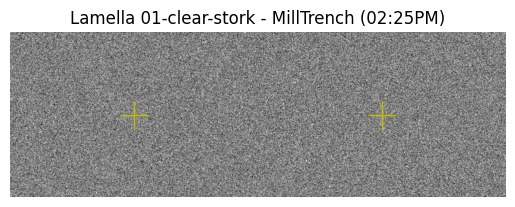

(480, 640, 4)


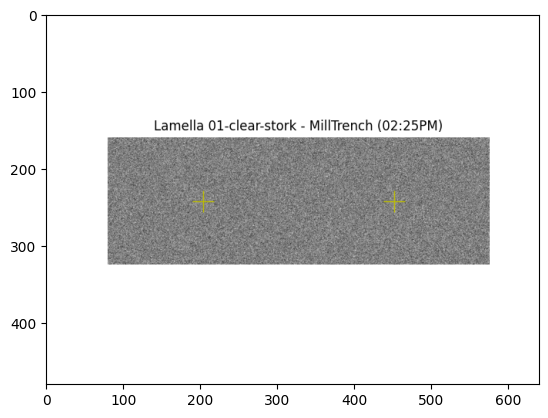

--------------------------------------------------------------------------------
02-valid-elf /home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/02-valid-elf
MillTrench MillTrench (02:25PM)


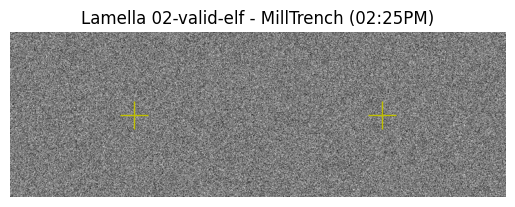

(480, 640, 4)


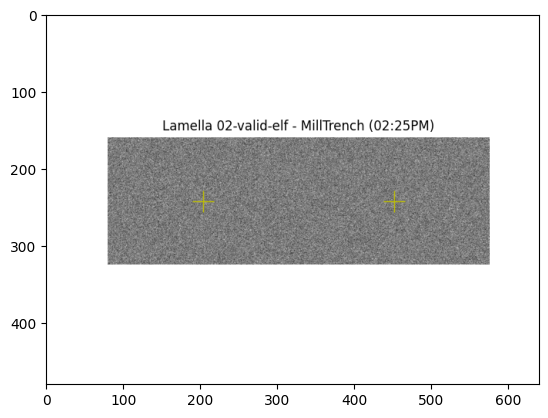

--------------------------------------------------------------------------------
03-ace-troll /home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/03-ace-troll
MillTrench MillTrench (02:25PM)


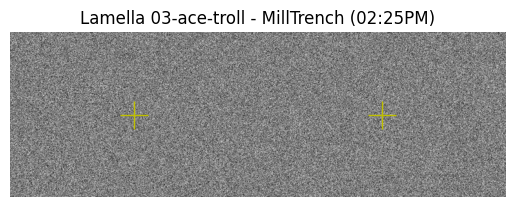

(480, 640, 4)


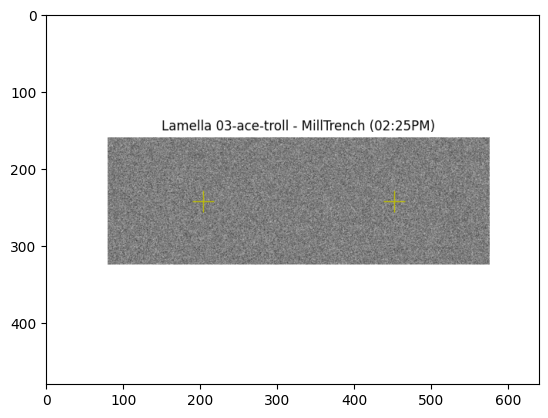

--------------------------------------------------------------------------------
04-clean-cobra /home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/04-clean-cobra
--------------------------------------------------------------------------------
05-dear-camel /home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/05-dear-camel
MillTrench MillTrench (04:44PM)


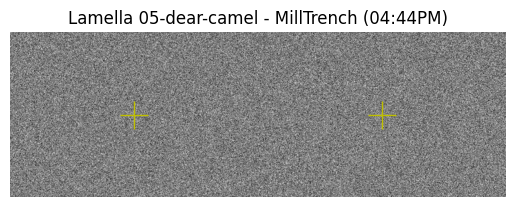

(480, 640, 4)


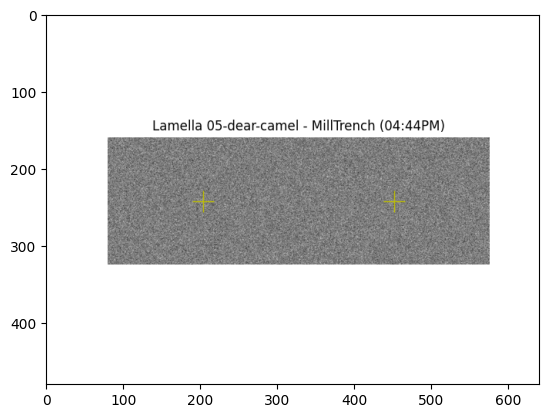

--------------------------------------------------------------------------------
06-big-turtle /home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/06-big-turtle


In [66]:
%load_ext autoreload
%autoreload 2

from autolamella.structures import Lamella, AutoLamellaStage, Experiment, AutoLamellaProtocol, AutoLamellaMethod
from pprint import pprint
from typing import List

import numpy as np
from fibsem.structures import FibsemImage
import glob
import os
import PIL.Image
import matplotlib.pyplot as plt


EXP_PATH = "/home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/experiment.yaml"
PROTOCOL_PATH = "/home/patrick/github/autolamella/autolamella/log/AutoLamella-2025-01-10-14-24/protocol.yaml"
exp = Experiment.load(EXP_PATH)
pos = exp.positions[0]
protocol = AutoLamellaProtocol.load(PROTOCOL_PATH)

print(protocol.method.workflow)

def get_completed_stages(pos: Lamella, method: AutoLamellaMethod) -> List[AutoLamellaStage]:
    """Get a list of completed worflow stages in a method for a given position"""
    # filter out the states that are not in the method (setups, finishes, etc.)
    workflow_states = sorted(pos.states.keys(), key=lambda x: x.value)
    workflow_states = [wf for wf in workflow_states if wf in method.workflow]

    return workflow_states


def get_workflow_snapshot(pos: Lamella, wf: AutoLamellaStage, target_size: int = 256) -> np.ndarray:
    """Get a snapshot of a workflow stage for a given position"""

    if not isinstance(target_size, int):
        target_size = int(target_size)

    # get the final high res images
    filenames = glob.glob(os.path.join(pos.path, f"*{wf.name}*final_high_res*.tif*"))
    
    # resize and stack the images for display
    sarr = None
    for fname in sorted(filenames):
        img = FibsemImage.load(fname)
        shape = img.data.shape
        resize_shape = (int(shape[0] * (target_size / shape[1])), target_size)
        arr = np.asarray(PIL.Image.fromarray(img.data).resize(resize_shape[::-1]))
        
        # stack
        if sarr is None:
            sarr = arr
        else:
            sarr = np.append(sarr, arr, axis=1)
    return sarr

target_size = 1536 / 4

# fig, ax = plt.subplots(len(exp.positions), 1, figsize=(10, 10))

for i, pos in enumerate(exp.positions):
    print("-"*80)
    print(pos.name, pos.path)

    stages_completed = get_completed_stages(pos, protocol.method)

    for wf in stages_completed:
        print(wf, pos.states[wf].completed)

        snapshot = get_workflow_snapshot(pos, wf, target_size=target_size)

        cx1 = snapshot.shape[1] // 4
        cx2 = snapshot.shape[1] // 2 + cx1
        cy = snapshot.shape[0] // 2

        fig = plt.figure()
        plt.title(f"Lamella {pos.name} - {pos.states[wf].completed}")
        plt.imshow(snapshot, cmap="gray")
        plt.plot([cx1, cx2], [cy, cy], "y+", ms=20)
        plt.axis("off")
        plt.show()

        # Convert to numpy array
        canvas = fig.canvas
        canvas.draw()
        # Get the RGBA buffer
        buf = canvas.buffer_rgba()
        # Convert to numpy array
        array = np.asarray(buf)
        plt.close()

        print(array.shape)

        plt.imshow(array)
        plt.show()

        # save array using PIL
        # img = PIL.Image.fromarray(array)
        # img.save(f"lamella_{pos.name}_{wf.name}.png")

        break

        # TODO: scalebar
